energy:(Hartree) 0.19456813255315636


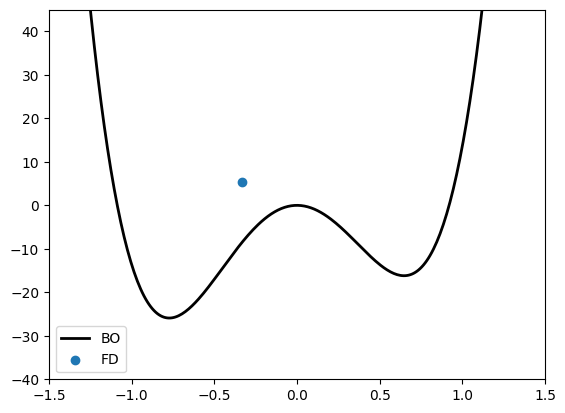

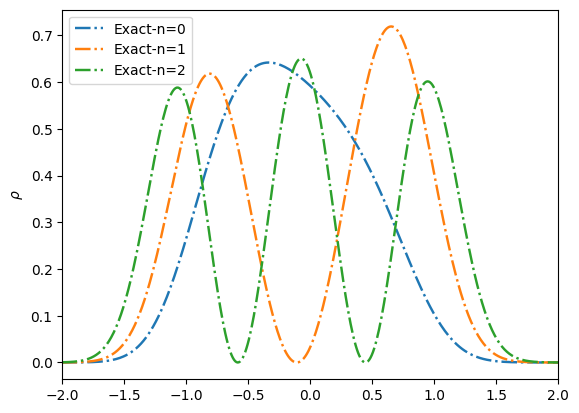

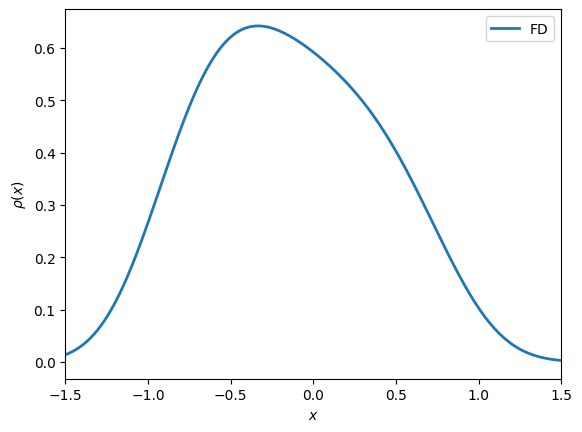

Excitation Energies:(Hartree)
[ 0.19456813  1.73513997  4.54932271  7.82492991 11.54729191 15.62874664
 20.0204506  24.68666156 29.60034415 34.74017723 40.0888437 ]


In [1]:
# import jax.numpy as np
import numpy as np


#mesh of the finite difference 
xmin = -10; xmax = 10; Nmesh = 2000
xmesh = np.linspace(xmin, xmax, Nmesh)
h = xmesh[1] - xmesh[0]

def Vpot(x):
    return 3*x**4 + x**3/2 - 3*x**2

def Vpot_harmonic(x):
    return x**2/2
    
def buildH(Vpot):
    Vx = Vpot(xmesh)
    Vx = np.diag(Vx,0,)
    H_kinetic = (-2 * np.diag(np.ones(Nmesh,), 0) + np.diag(np.ones(Nmesh - 1, ), 1) + np.diag(np.ones(Nmesh - 1, ), -1))/(2 * h**2)

    H = Vx - H_kinetic
    
    return H 

if __name__=='__main__':

    hartree2ev = 27.2107
    H = buildH(Vpot)
    w, v = np.linalg.eigh(H)
    idx_sorted = np.argsort(w)
    w,v = w[idx_sorted], v[:, idx_sorted]
    gs_wf = v[:,0]
    normalize_factor = (gs_wf**2).sum() * h
    # rescale to probability amplitude
    gs = gs_wf**2 / normalize_factor
    
    nlowest = 1
    print ('energy:(Hartree)', w[0])

    import matplotlib.pyplot as plt

    xmes_argmax = gs.argmax()
    plt.plot(xmesh, Vpot(xmesh)*hartree2ev, 'k-', lw=2, label="BO")
    plt.scatter(xmesh[xmes_argmax], w[0:nlowest]*hartree2ev,label="FD")
    plt.xlim([-1.5,1.5])
    plt.ylim([-40,45])
    plt.legend()
    plt.show()

    state_indices = np.array([0,1,2])
    for i in state_indices:
        exact_wf_on_mesh = v[:, i]
        normalize_factor = (exact_wf_on_mesh**2).sum() * h
        exact_prob_density = exact_wf_on_mesh**2 / normalize_factor
        plt.plot(xmesh, exact_prob_density, "-.", label=f"Exact-n={i}", lw=1.75)
    plt.xlim([-2.0, 2.0])
    plt.legend()
    plt.ylabel(r"$\rho$")
    plt.show()

    plt.plot(xmesh, gs, label='FD', lw=2)
    plt.xlim([-1.5,1.5])
    plt.xlabel('$x$')
    plt.ylabel(r'$\rho(x)$')
    plt.legend()
    plt.show()

    print("Excitation Energies:(Hartree)")
    num_of_orbs = 10
    print(f"{w[:num_of_orbs+1:]}")

In [2]:
H_harmonic = buildH(Vpot_harmonic)
w_harmonic, v_harmonic = np.linalg.eigh(H_harmonic)


In [3]:
inspect_x = 1.0
smaller_index = np.where(xmesh < inspect_x)[-1][-1]
larger_index = np.where(xmesh > inspect_x)[0][0]
inspect_index = int((larger_index+smaller_index)/2)
print(inspect_index)
print(f"Larger {larger_index}\nSmaller {smaller_index}")

1099
Larger 1100
Smaller 1099


In [4]:
from flax import linen as flax_nn
class MLPSingleFlow(flax_nn.Module):
    """A simple MLP flow"""

    out_dims: int
    mlp_width: int
    mlp_depth: int
    kernel_init_width: float = 0.01
    bias_init_width:float = 10.0

    @flax_nn.compact
    def __call__(self, x):
        _init_x = x
        for i in range(self.mlp_depth):
            x = x.reshape(
                    -1,
            )
            x = flax_nn.Dense(
                self.mlp_width,
                kernel_init=flax_nn.initializers.truncated_normal(stddev=self.kernel_init_width,lower=-1e-3,upper=1e3),
                bias_init=flax_nn.initializers.truncated_normal(stddev=self.bias_init_width,lower=-1e-3,upper=1e3)
            )(x)
            x = flax_nn.tanh(x)
            x = flax_nn.Dense(self.out_dims,kernel_init=flax_nn.initializers.truncated_normal(stddev=self.kernel_init_width,lower=-1e-3,upper=1e3))(x)
        x = _init_x + x

        return x



Inspecting at x_exact=-0.104555555: The actual node point for 1-st excited state of Exact wavefunction
(anharmonic,exact) rho_1/rho_0 = 0.00006

Inspecting at x_vmc=-0.05588: the node point for 1-st excited state of Trained wavefunction
(anharmonic,flowed) rho_1/rho_0 = nan

Inspecting at f(x_vmc) = f(-0.05588) = z=0: the corresponding base wavefunction with the coordinate z that x_vmc is flowed from
(harmonic base) rho_1/rho_0 = 0.00005


/tmp/ipykernel_2513711/136712365.py:121: RuntimeWarning: invalid value encountered in scalar divide
  f"(anharmonic,flowed) rho_{j}/rho_{i} = {(inspect_rho_anharmonic_wf_ansatz[j]/inspect_rho_anharmonic_wf_ansatz[i]):.5f}"


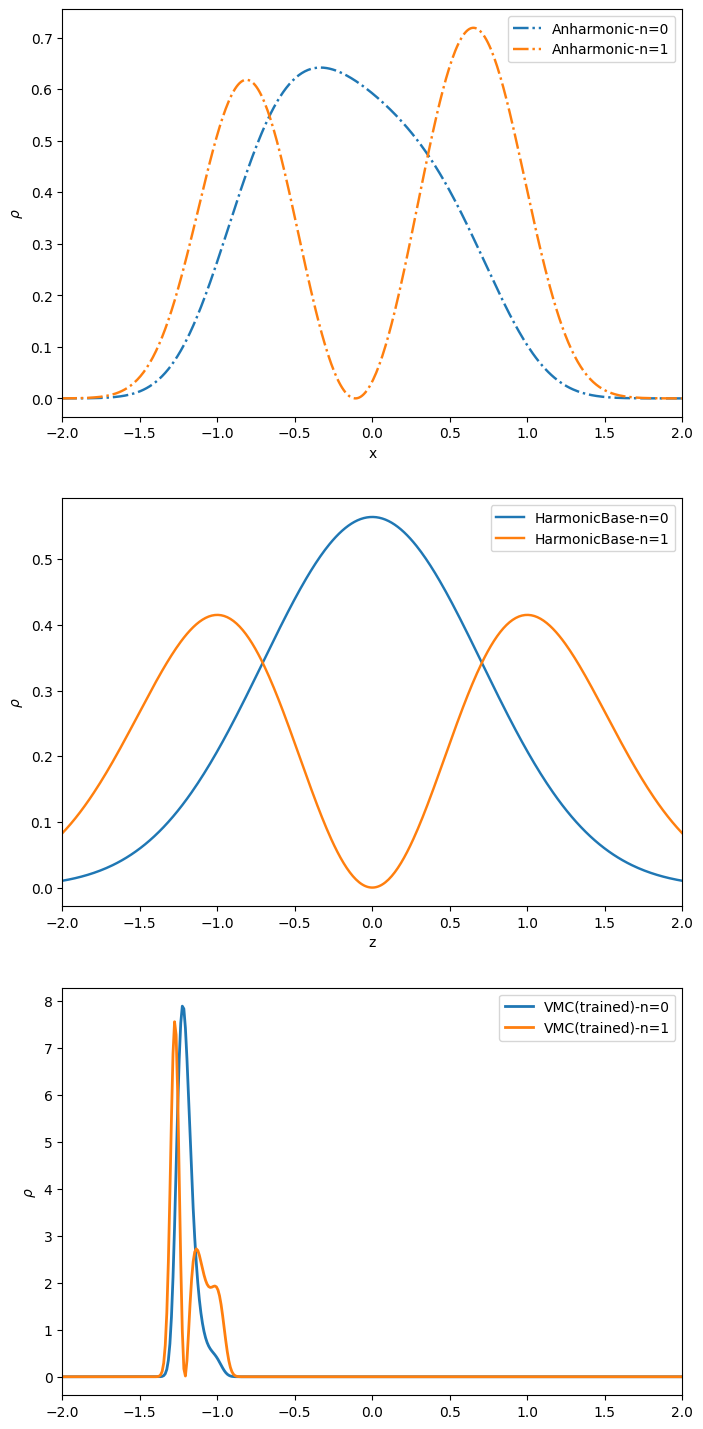

In [6]:
def find_index(inspect,mesh):
    smaller = np.where(mesh < inspect)[-1][-1]
    larger = np.where(mesh > inspect)[0][0]
    index = int((larger + smaller)/2)
    return index

import sys
import pickle
sys.path.append("../")
from VMC.utils import WFAnsatz
import jax
import jax.numpy as jnp
from flax import linen as flax_nn
import itertools

ckptfilename = "/home/callo/This_Is_Callo/Research_Realm/2024july1dquantum/figure/OriginHermite/StateIndices[0, 1]/batch_5000/mlpwid_500/mlpdep_2/initlr_0.0010/mcstp_50/thrstp_20/acc_1/xinitwidth_2.0/paramsinitwidth_0.01/NoGradientClip/log-domain/HydrogenLoss/checkpoint.pkl"
with open(ckptfilename,"rb") as f:
    ckpt = pickle.load(f)
params = ckpt["params"]
mlp_width = ckpt["mlp_width"]
mlp_depth = ckpt["mlp_depth"]

state_indices = np.array([0,1])

key = jax.random.PRNGKey(42)
flow = MLPSingleFlow(1,mlp_width=mlp_width,mlp_depth=mlp_depth)
x_dummy = jnp.zeros((1,))
wf_ansatz_obj = WFAnsatz(flow=flow)
wf_ansatz_single= wf_ansatz_obj.wf_ansatz
wf_ansatz = jax.vmap(wf_ansatz_single,in_axes=(None,0,0))

log_wf_ansatz_obj = WFAnsatz(flow=flow)
log_wf_ansatz_single= wf_ansatz_obj.wf_ansatz
log_wf_ansatz = jax.vmap(wf_ansatz_single,in_axes=(None,0,0))

xmesh_tiled = np.tile(xmesh, state_indices.shape[0]).reshape(
        state_indices.shape[0], Nmesh
    )

# node for exact anharmonic
anhar_exact_node_x = -0.104555555
anhar_exact_node_inspect_index = find_index(anhar_exact_node_x,xmesh)
# node after ACTUALLY Train!
inspect_x = -0.05588
inspect_index = find_index(inspect_x,xmesh)
z_mesh = xmesh
# inspect_z = flow.apply(params,jnp.array(inspect_x))
inspect_z = 0
inspect_z_index = find_index(inspect_z,z_mesh)

wfs_ansatz_on_mesh = jax.vmap(
        wf_ansatz,
        in_axes=(None, 1, None),
        out_axes=0,
    )(params, xmesh_tiled, state_indices)
log_wfs_ansatz_on_mesh = jax.vmap(
        log_wf_ansatz,
        in_axes=(None, 1, None),
        out_axes=0,
    )(params, xmesh_tiled, state_indices)

inspect_rho_anharmonic = []
inspect_rho_harmonic = []
inspect_rho_anharmonic_wf_ansatz = []

fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(8,18))
for i in state_indices:
    # exact wf of anharmonic potential
    exact_wf_on_mesh = v[:, i]
    normalize_factor = (exact_wf_on_mesh**2).sum() * h
    exact_wf_on_mesh = exact_wf_on_mesh**2 / normalize_factor

    # exact wf of harmonic potential
    # aka, the base in z space!
    exact_wf_on_mesh_harmonic = v_harmonic[:, i]
    normalize_factor_harmonic = (exact_wf_on_mesh_harmonic**2).sum() * h
    exact_wf_on_mesh_harmonic = exact_wf_on_mesh_harmonic**2 / normalize_factor_harmonic

    # vmc wavefunction
    wf_ansatz_on_mesh = wfs_ansatz_on_mesh[:, i]
    normalize_factor_wf_ansatz = (wf_ansatz_on_mesh**2).sum() * h
    wf_ansatz_on_mesh = (wf_ansatz_on_mesh**2) / normalize_factor_wf_ansatz

    inspect_rho_anharmonic.append(exact_wf_on_mesh[anhar_exact_node_inspect_index])
    inspect_rho_harmonic.append(exact_wf_on_mesh_harmonic[inspect_z_index])
    inspect_rho_anharmonic_wf_ansatz.append(wf_ansatz_on_mesh[inspect_index])

    ax1.plot(xmesh, exact_wf_on_mesh, "-.", label=f"Anharmonic-n={i}", lw=1.75)
    ax2.plot(xmesh, exact_wf_on_mesh_harmonic, "-", label=f"HarmonicBase-n={i}", lw=1.75)
    ax3.plot(xmesh, wf_ansatz_on_mesh, label=f"VMC(trained)-n={i}", lw=2)
ax1.set_xlim([-2.0, 2.0])
ax2.set_xlim([-2.0, 2.0])
ax1.legend()
ax2.legend()
ax1.set_xlabel("x")
ax2.set_xlabel("z")
ax1.set_ylabel(r"$\rho$")
ax2.set_ylabel(r"$\rho$")
ax3.set_xlim([-2.0, 2.0])
ax3.legend()
ax3.set_ylabel(r"$\rho$")
# plt.show()

inspect_rho_anharmonic = np.array(inspect_rho_anharmonic)
inspect_rho_harmonic = np.array(inspect_rho_harmonic)
inspect_rho_anharmonic_wf_ansatz = np.array(inspect_rho_anharmonic_wf_ansatz)

print(
    f"Inspecting at x_exact={anhar_exact_node_x}: The actual node point for 1-st excited state of Exact wavefunction"
)
for i,j in itertools.combinations(state_indices,r=2):
    print(
        f"(anharmonic,exact) rho_{j}/rho_{i} = {(inspect_rho_anharmonic[j]/inspect_rho_anharmonic[i]):.5f}"
        )

print(
    f"\nInspecting at x_vmc={inspect_x}: the node point for 1-st excited state of Trained wavefunction"
)
for i,j in itertools.combinations(state_indices,r=2):
    print(
        f"(anharmonic,flowed) rho_{j}/rho_{i} = {(inspect_rho_anharmonic_wf_ansatz[j]/inspect_rho_anharmonic_wf_ansatz[i]):.5f}"
        )



print(
    f"\nInspecting at f(x_vmc) = f({inspect_x}) = z={inspect_z}: the corresponding base wavefunction with the coordinate z that x_vmc is flowed from"
)
for i,j in itertools.combinations(state_indices,r=2):
    print(
        f"(harmonic base) rho_{j}/rho_{i} = {(inspect_rho_harmonic[j]/inspect_rho_harmonic[i]):.5f}"
    )



In [26]:
for ins_x in np.linspace(0,2,100):
    # node for exact anharmonic
    anhar_exact_node_x = ins_x
    anhar_exact_node_inspect_index = find_index(anhar_exact_node_x,xmesh)

    inspect_rho_anharmonic = []

    for i in state_indices:
        # exact wf of anharmonic potential
        exact_wf_on_mesh = v[:, i]
        normalize_factor = (exact_wf_on_mesh**2).sum() * h
        exact_wf_on_mesh = exact_wf_on_mesh**2 / normalize_factor
        inspect_rho_anharmonic.append(exact_wf_on_mesh[anhar_exact_node_inspect_index])

    inspect_rho_anharmonic = np.array(inspect_rho_anharmonic)

    print(
        f"Inspecting at x_exact={anhar_exact_node_x:.3f}: "
    )
    for i,j in itertools.combinations(state_indices,r=2):
        print(
            f"(anharmonic,exact) rho_{j}/rho_{i} = {(inspect_rho_anharmonic[j]/inspect_rho_anharmonic[i]):.5f}"
            )


Inspecting at x_exact=0.000: 
(anharmonic,exact) rho_1/rho_0 = 0.05061
Inspecting at x_exact=0.020: 
(anharmonic,exact) rho_1/rho_0 = 0.07228
Inspecting at x_exact=0.040: 
(anharmonic,exact) rho_1/rho_0 = 0.09782
Inspecting at x_exact=0.061: 
(anharmonic,exact) rho_1/rho_0 = 0.12723
Inspecting at x_exact=0.081: 
(anharmonic,exact) rho_1/rho_0 = 0.16047
Inspecting at x_exact=0.101: 
(anharmonic,exact) rho_1/rho_0 = 0.19751
Inspecting at x_exact=0.121: 
(anharmonic,exact) rho_1/rho_0 = 0.23829
Inspecting at x_exact=0.141: 
(anharmonic,exact) rho_1/rho_0 = 0.28273
Inspecting at x_exact=0.162: 
(anharmonic,exact) rho_1/rho_0 = 0.33078
Inspecting at x_exact=0.182: 
(anharmonic,exact) rho_1/rho_0 = 0.38232
Inspecting at x_exact=0.202: 
(anharmonic,exact) rho_1/rho_0 = 0.43727
Inspecting at x_exact=0.222: 
(anharmonic,exact) rho_1/rho_0 = 0.49551
Inspecting at x_exact=0.242: 
(anharmonic,exact) rho_1/rho_0 = 0.55693
Inspecting at x_exact=0.263: 
(anharmonic,exact) rho_1/rho_0 = 0.62139
Inspec